# Fit Pressure power atmospheric transparency Emulator 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/10/28
- last update : 2023/10/29


This emulator is based from datagrid of atmospheric transparencies extracted from libradtran


https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/FitThrouput/202307/FitAtmosphericParamsFromSpectra-HD185975-20230117-empty~holo4_003_psf2dffm-rebin2.ipynb


https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/FitThrouput/202307/FitAtmosphericParamsFromSpectra-HD185975-20230117-empty~holo4_003_psf2dffm-rebin2.ipynb


In [1]:
import numpy as np
import pandas as pd
import os
from scipy import interpolate
from astropy.io import fits
from astropy.table import Table
import seaborn as sns

from scipy.optimize import curve_fit,least_squares

In [2]:
from simpleemulator.simpleatmemulator import Dict_Of_sitesAltitudes,Dict_Of_sitesPressures
from simpleemulator.simpleatmemulator  import SimpleAtmEmulator

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:

################################################################################################################
#  
################################################################################################################

class FitAtmosphericPressureParams:
    """
    Generic class to fit a generic atmospheric profile wrt wavelength and airmass
    
    The atmospheric profile could be the transmission, the optical depth or the extinction
    """
    def __init__(self) :
        """
        Init the fit class
        """
        print("Init FitAtmosphericPressureParams")
        self.nfitcalls = 0
        
         
    def printinfo(self):  
        print(f"FitAtmosphericPressureParams : {self.__class__.__name__}")

  
    def set_reference_data(self,data):
        """
        the reference data are the optical depth at reference LSST site
        """
        self.reference_data = data

    
    def printparams(self,params):
        """
        Print parameters
        """
        
        param = params[0]
        print(f" call{self.nfitcalls} params = {param}")
            
                  
        
        
    def func_pressuremodel(self,x,*params):
        """
        Function  for fitting the model using curve_fit

        - x is the array of pressure ratio
        
        
        return the product of the optical-depth at LSST site multiplied by the pressure ratio to the power given by the param
        
        """           
        param=params[0]      
        return  self.reference_data*np.power(x,param) 

             

    def fit_pressuremodel(self ,X,Y):
        """
        Do the fit by calling curve_fit
            provide the data 
            X : the pressure ratio
            Y : the optical depth in the data

        """

        self.params0 = np.array([1.0])
        
        nfitcalls = 0
        res_fit = curve_fit(self.func_pressuremodel,X,Y,p0=self.params0,full_output=True)
        

        popt = res_fit[0]
        pcov = res_fit[1]
        cf_dict = res_fit[2]
    
        # compute the errors on fitted parameters
        sigmas = np.sqrt(np.diagonal(pcov))
        # compute the normalized residuals  
        normresiduals=cf_dict['fvec']
        # compute the chi2 from the 
        chi2= np.sum(normresiduals**2)
        ndf = len(normresiduals)-len(popt)
        chi2_per_ndf = chi2/ndf
        


         # compute relative residuals
        self.all_residuals =  (Y - self.func_pressuremodel(X,popt))


        return popt,pcov,cf_dict,sigmas,normresiduals,chi2,ndf,chi2_per_ndf
   
################################################################################################        


In [6]:
Dict_Of_sitesPressures

{'LSST': 731.50433,
 'CTIO': 774.6052,
 'OHP': 937.22595,
 'PDM': 710.90637,
 'OMK': 600.17224,
 'OSL': 1013.0}

In [7]:
obs_str_ref = 'LSST'
std_pressure_ref = Dict_Of_sitesPressures[obs_str_ref]
info_ref = f"{obs_str_ref} :  P_std = {std_pressure_ref:.0f} hPa"  

obs_str_omk = 'OMK'
std_pressure_omk = Dict_Of_sitesPressures[obs_str_omk]
info_omk = f"{obs_str_omk} :  P_std = {std_pressure_omk:.0f} hPa"  

obs_str_osl = 'OSL'
std_pressure_osl = Dict_Of_sitesPressures[obs_str_osl]
info_osl = f"{obs_str_osl} :  P_std = {std_pressure_osl:.0f} hPa"  

In [8]:
emul_ref =  SimpleAtmEmulator(obs_str=obs_str_ref)
emul_omk =  SimpleAtmEmulator(obs_str=obs_str_omk)
emul_osl =  SimpleAtmEmulator(obs_str=obs_str_osl)

Observatory LSST found in preselected observation sites
Observatory OMK found in preselected observation sites
Observatory OSL found in preselected observation sites


In [9]:
WL = emul_ref.GetWL()
airmasses = emul_ref.AIRMASS
NAM = len(airmasses)
hls_colors = sns.color_palette("hls", NAM)
#sns.palplot(hls_colors)

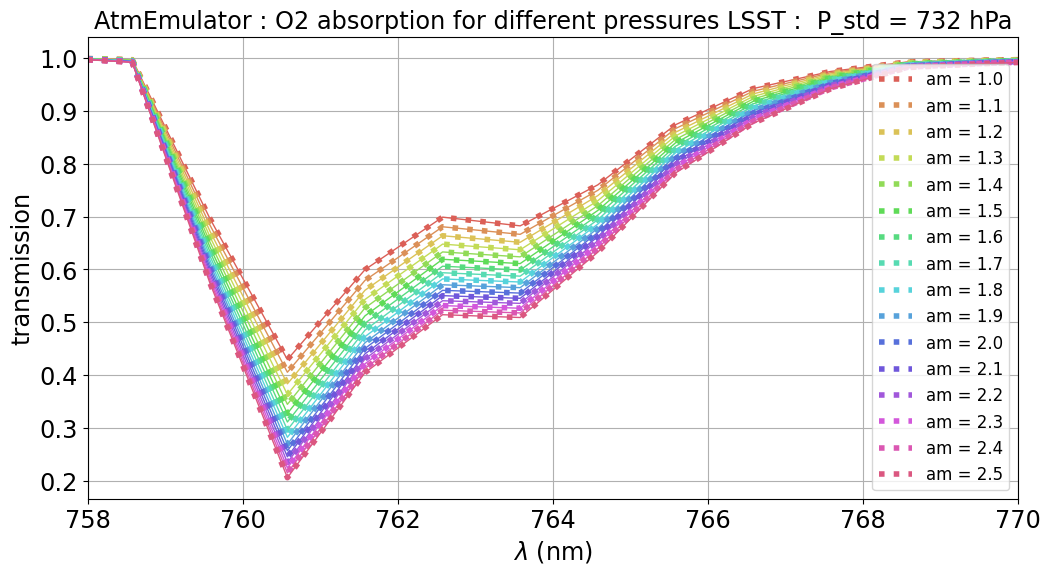

In [10]:
emul = emul_ref

fig, ax = plt.subplots()
for idx,am in enumerate(airmasses):
    label = f"am = {am:.1f}"
    transm= emul.GetO2absTransparencyArray(WL,am)
    
    
    ax.plot(WL,transm,":",color=hls_colors[idx],label=label,lw=4)
    ax.plot(WL,transm,"-",color=hls_colors[idx],lw=1)
        

title = f"AtmEmulator : O2 absorption for different pressures " + info_ref
ax.set_title(title)
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_xlim(758.,770.)
# place a text box in upper left in axes coords
#ax.text(0.5, 0.05, textboxstr, transform=ax.transAxes, fontsize=14,verticalalignment='bottom', bbox=textboxprops)
ax.grid()
ax.legend()

https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/FitThrouput/202307/FitAtmosphericParamsFromSpectra-HD185975-20230117-empty~holo4_003_psf2dffm-rebin2.ipynb

In [11]:
def FlattenDataCurve(emul,all_am,wlmin=758,wlmax=770):
    
    WL = emul.GetWL()
    selected_wl_indexes = np.where(np.logical_and(WL>=wlmin,WL<=wlmax))[0]
       
    nam = len(all_am)
    nwls = len(selected_wl_indexes)
    wls = WL[selected_wl_indexes]
                                                         
    X = np.zeros((nam,nwls))
    Y = np.zeros((nam,nwls))
                                
    for idx,am in enumerate(all_am):
        
        optical_index =  -np.log(emul.GetO2absTransparencyArray(wls,am))
        X[idx,:] = wls
        Y[idx,:] = optical_index
        
        
    X=X.flatten()
    Y=Y.flatten()
    return X,Y

In [12]:
wl_arr_ref,od_arr_ref = FlattenDataCurve(emul_ref,airmasses) 
wl_arr_omk,od_arr_omk = FlattenDataCurve(emul_omk,airmasses) 
wl_arr_osl,od_arr_osl = FlattenDataCurve(emul_osl,airmasses) 

Text(0, 0.5, 'O2 optical depth')

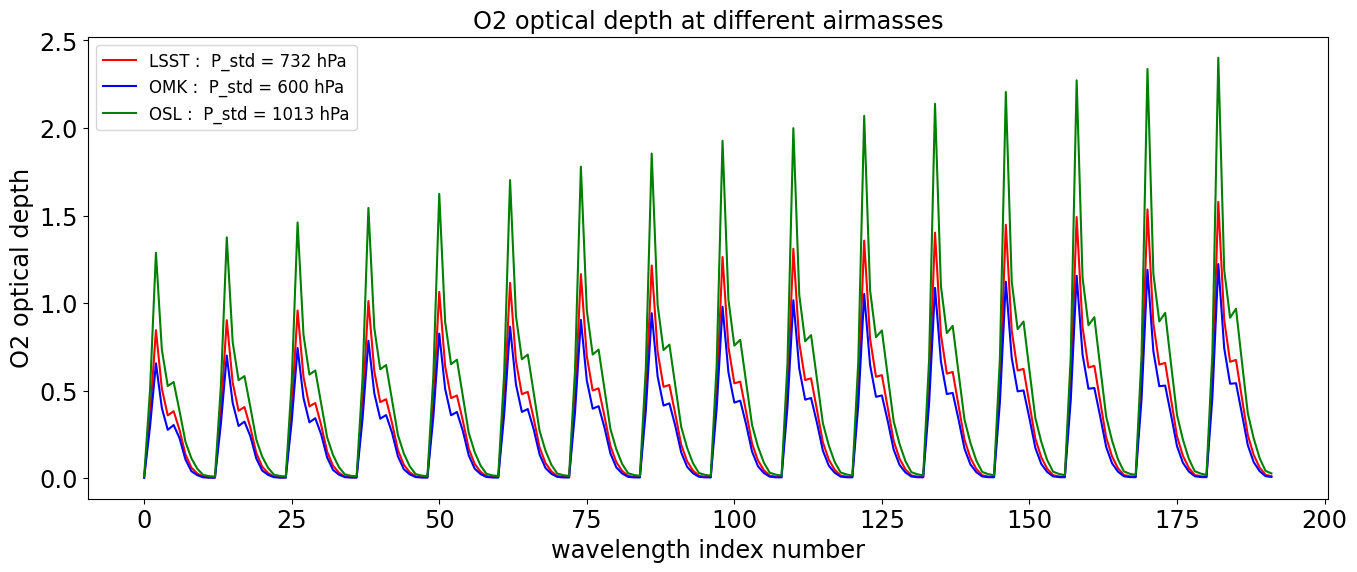

In [13]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(od_arr_ref,'r-',label=info_ref)
ax.plot(od_arr_omk,'b-',label=info_omk)
ax.plot(od_arr_osl,'g-',label=info_osl)
ax.legend()
ax.set_title("O2 optical depth at different airmasses")
ax.set_xlabel("wavelength index number")
ax.set_ylabel("O2 optical depth")

# Build Data / Reference

In [14]:
#'LSST': 731.50433,
# 'CTIO': 774.6052,
# 'OHP': 937.22595,
# 'PDM': 710.90637,
# 'OMK': 600.17224,
# 'OSL': 1013.0

In [15]:
all_datasites = ['OMK','PDM','CTIO','OHP','OSL']

In [16]:
all_wls = []
all_data_ods = []
all_refdata_ods = []
all_pressratio = []

for datasite in all_datasites:
    p_site = Dict_Of_sitesPressures[datasite]
    pvspref = p_site/std_pressure_ref
    emul =  SimpleAtmEmulator(obs_str = datasite)
    wls,ods = FlattenDataCurve(emul,airmasses) 
    nwls = len(wls)
    pressratio = np.ones(nwls)*pvspref
    all_wls.append(wls)
    all_data_ods.append(ods)
    all_pressratio.append(pressratio)
    all_refdata_ods.append(od_arr_ref)
    
all_pressratio = np.concatenate(all_pressratio) 
all_data_ods = np.concatenate(all_data_ods)
all_refdata_ods = np.concatenate(all_refdata_ods)
all_wls = np.concatenate(all_wls)

Observatory OMK found in preselected observation sites
Observatory PDM found in preselected observation sites
Observatory CTIO found in preselected observation sites
Observatory OHP found in preselected observation sites
Observatory OSL found in preselected observation sites


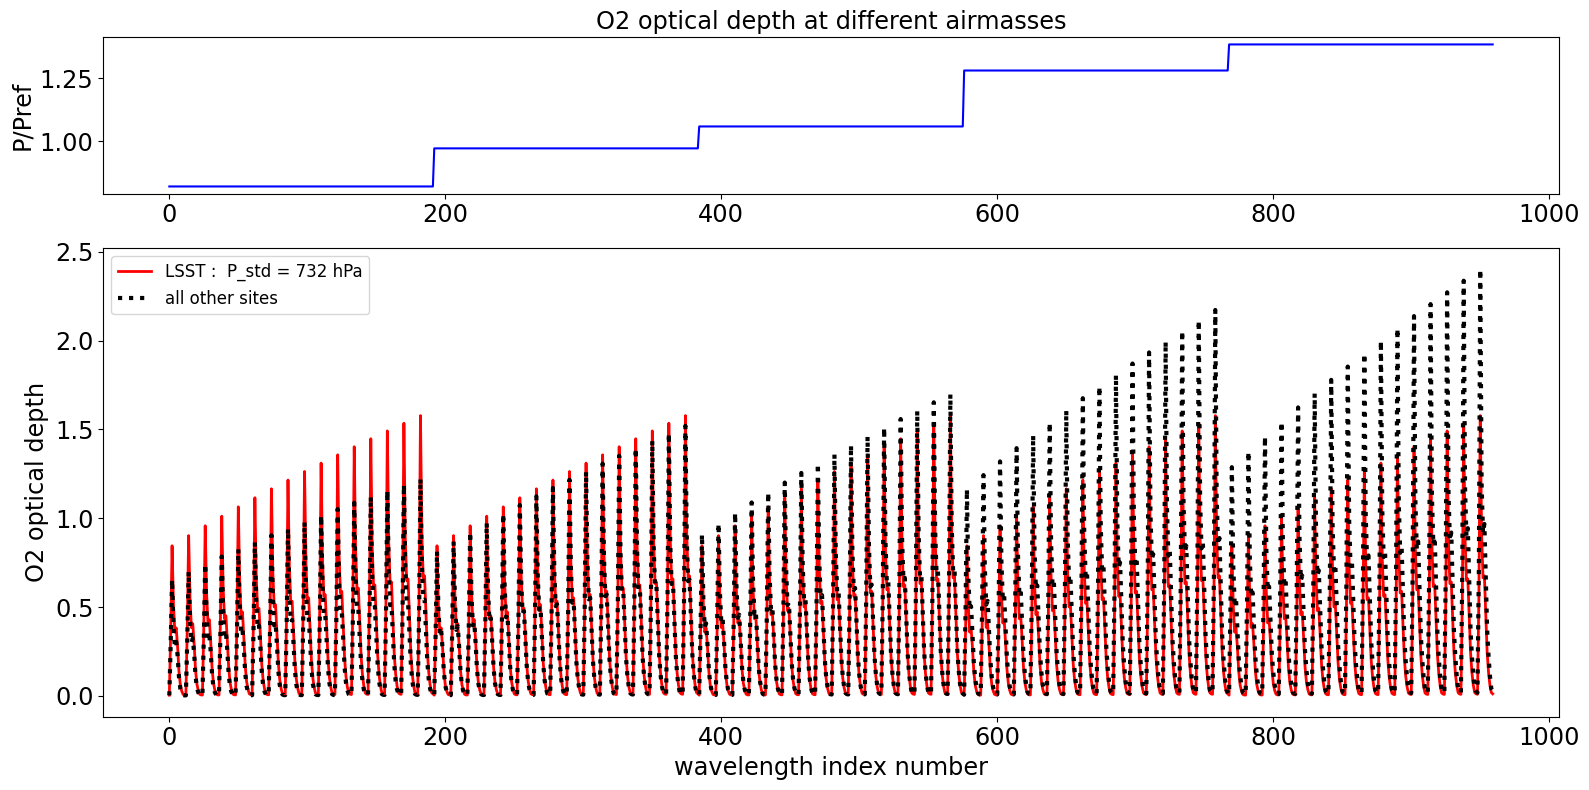

In [17]:
fig = plt.figure(figsize=(16,8),tight_layout=True)
gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3])

ax1 = fig.add_subplot(gs[0])
ax1.plot(all_pressratio,'b-')
ax1.set_ylabel("P/Pref")
ax1.set_title("O2 optical depth at different airmasses")

ax2 = fig.add_subplot(gs[1])
ax2.plot(all_refdata_ods,'r-',label=info_ref,lw=2)
ax2.plot(all_data_ods,'k:',label="all other sites",lw=3)
ax2.set_xlabel("wavelength index number")
ax2.set_ylabel("O2 optical depth")
ax2.legend()

In [18]:
fitter = FitAtmosphericPressureParams()

Init FitAtmosphericPressureParams


In [19]:
fitter.set_reference_data(all_refdata_ods)

In [20]:
popt,pcov,cf_dict,sigmas,normresiduals,chi2,ndf,chi2_per_ndf = fitter.fit_pressuremodel(all_pressratio,all_data_ods)

In [21]:
popt

array([1.16306918])

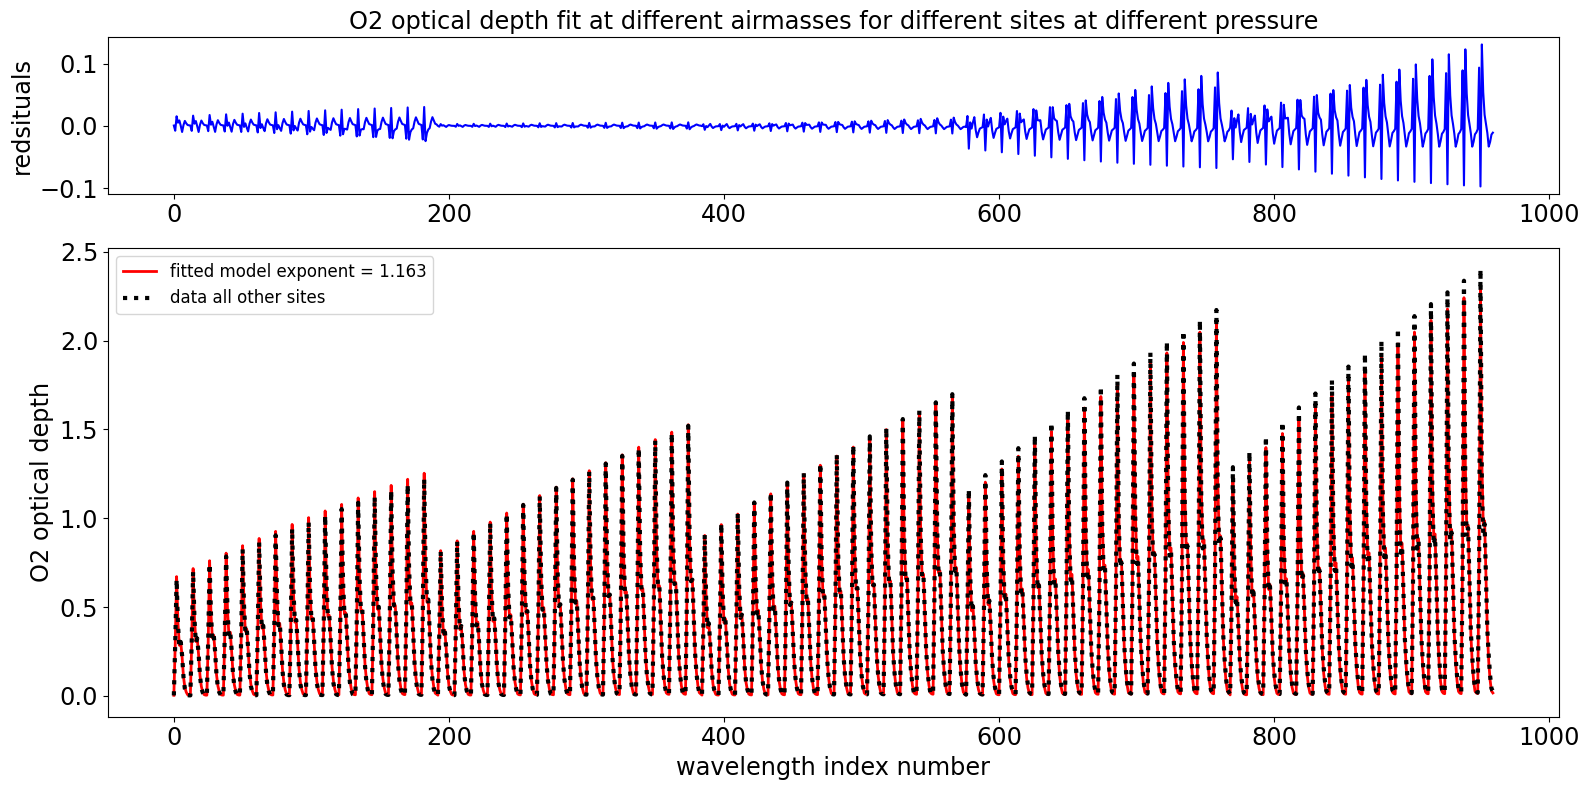

In [22]:
fig = plt.figure(figsize=(16,8),tight_layout=True)
gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3])

ax1 = fig.add_subplot(gs[0])
ax1.plot(normresiduals,'b-')
ax1.set_ylabel("redsituals")
ax1.set_title("O2 optical depth fit at different airmasses for different sites at different pressure")

ax2 = fig.add_subplot(gs[1])

fitted_model_ods = fitter.func_pressuremodel(all_pressratio,popt)
ax2.plot(fitted_model_ods,'r-',label=f"fitted model exponent = {popt[0]:.3f}",lw=2)
ax2.plot(all_data_ods,'k:',label="data all other sites",lw=3)
ax2.set_xlabel("wavelength index number")
ax2.set_ylabel("O2 optical depth")
ax2.legend()

In [23]:
popt

array([1.16306918])

In [24]:
alphas = np.linspace(0.1,2.0,50)

In [25]:
x = alphas
y = np.zeros(len(x))

for idx,alpha in enumerate(alphas):
    params = np.array([alpha])
    model = fitter.func_pressuremodel(all_pressratio,params)
    chi2 = np.sum((all_data_ods - model)**2) 
    y[idx] = chi2
    

Text(0.5, 1.0, 'Optimisation')

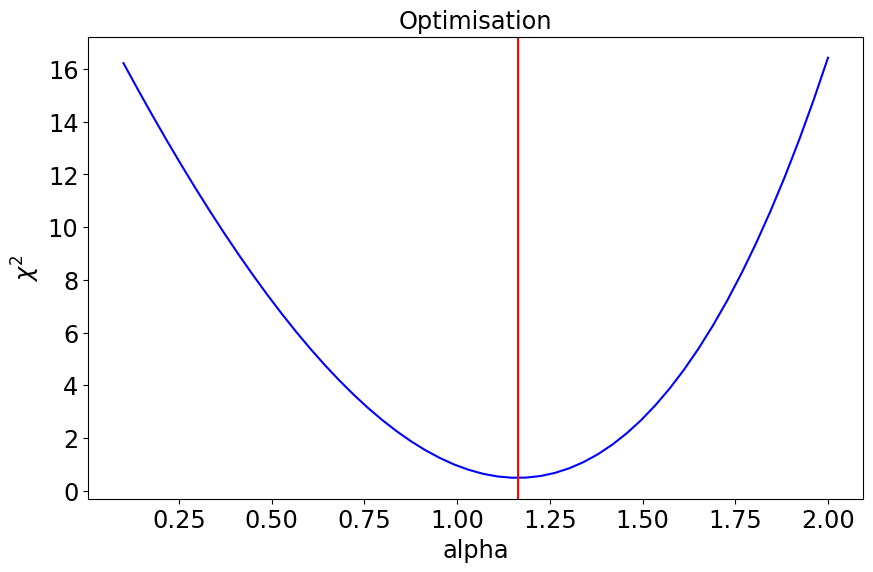

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x,y,"b-")
ax.axvline(popt[0],color="r")
ax.set_xlabel("alpha")
ax.set_ylabel("$\chi^2$")
ax.set_title("Optimisation")